In [1]:
import pandas as pd
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
import matplotlib.ticker as tck
from multiprocessing import Pool, cpu_count

In [2]:
data = pd.read_csv("data.csv")
phase_scan = pd.read_csv("dc.csv")
heating_voltage = phase_scan["Heating"].to_numpy().T
detector_1 = data["Norm DC1 (V)"] # phase_scan["Detector 1"].to_numpy().T
detector_2 = data["Norm DC2 (V)"] #phase_scan["Detector 2"].to_numpy().T
detector_3 = data["Norm DC3 (V)"] #phase_scan["Detector 3"].to_numpy().T



In [3]:
"""plt.plot(heating_voltage, detector_1, label="Detector 1")
plt.plot(heating_voltage, detector_2, label="Detector 2")
plt.plot(heating_voltage, detector_3, label="Detector 3")
plt.xlabel("Heating Voltage [V]", fontsize=12)
plt.ylabel("Detector Voltage [V]", fontsize=12)
plt.legend(fontsize=12, bbox_to_anchor=(1,1))
plt.grid(True)
plt.title("Phase Scan", fontsize=12)
plt.show()"""

'plt.plot(heating_voltage, detector_1, label="Detector 1")\nplt.plot(heating_voltage, detector_2, label="Detector 2")\nplt.plot(heating_voltage, detector_3, label="Detector 3")\nplt.xlabel("Heating Voltage [V]", fontsize=12)\nplt.ylabel("Detector Voltage [V]", fontsize=12)\nplt.legend(fontsize=12, bbox_to_anchor=(1,1))\nplt.grid(True)\nplt.title("Phase Scan", fontsize=12)\nplt.show()'

In [4]:
def scale_edata(data):
    return 2 * (data - min(data)) / (max(data) - min(data)) - 1

In [5]:
I_min = [min(detector_1), min(detector_2), min(detector_3)]
I_max = [max(detector_1), max(detector_2), max(detector_3)]
dc_scaled = [detector_1, detector_2, detector_3] #[2 * (detector_1 - I_min[0]) / (I_max[0] - I_min[0]) - 1,
            # 2 * (detector_2 - I_min[1]) / (I_max[1] - I_min[1]) - 1,
            # 2 * (detector_3 - I_min[2]) / (I_max[2] - I_min[2]) - 1]

In [6]:
"""plt.plot(heating_voltage, dc_scaled[0], label="Detector 1")
plt.plot(heating_voltage, dc_scaled[1], label="Detector 2")
plt.plot(heating_voltage, dc_scaled[2], label="Detector 3")
plt.legend(fontsize=12, bbox_to_anchor=(1,1))
plt.grid(True)
plt.xlabel("Heating Voltage [V]", fontsize=12)
plt.ylabel("Scaled Voltage", fontsize=12)
plt.title("Scaled DC-Signals", fontsize=12)
plt.show()"""

'plt.plot(heating_voltage, dc_scaled[0], label="Detector 1")\nplt.plot(heating_voltage, dc_scaled[1], label="Detector 2")\nplt.plot(heating_voltage, dc_scaled[2], label="Detector 3")\nplt.legend(fontsize=12, bbox_to_anchor=(1,1))\nplt.grid(True)\nplt.xlabel("Heating Voltage [V]", fontsize=12)\nplt.ylabel("Scaled Voltage", fontsize=12)\nplt.title("Scaled DC-Signals", fontsize=12)\nplt.show()'

In [7]:
"""f,ax=plt.subplots(1)
ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%d $\pi$'))
ax.plot((heating_voltage - heating_voltage[0])  / heating_voltage[96] * 2 * np.pi, dc_scaled[0], label="Detector 1")
ax.plot((heating_voltage - heating_voltage[0])  / heating_voltage[96] * 2 * np.pi, dc_scaled[1], label="Detector 2")
ax.plot((heating_voltage - heating_voltage[0])  / heating_voltage[96] * 2 * np.pi, dc_scaled[2], label="Detector 3")



print(np.where(1- dc_scaled[0] < 1e-2)[0])
print(np.where(1- dc_scaled[1] < 1e-2)[0])
print(np.where(1- dc_scaled[2] < 1e-2)[0])

print(0)
print(50 / 96 * 360 - 103 / 96 * 360 + 360)
print(93 / 96 * 2 * np.pi / np.pi * 180 - 103 / 96 * 360 + 360)
plt.legend(fontsize=12, bbox_to_anchor=(1,1))
plt.grid(True)
plt.xlabel("Heating Voltage [V]", fontsize=12)
plt.ylabel("Scaled Voltage", fontsize=12)
plt.title("Scaled DC-Signals", fontsize=12)
plt.show()"""

'f,ax=plt.subplots(1)\nax.xaxis.set_major_formatter(tck.FormatStrFormatter(\'%d $\\pi$\'))\nax.plot((heating_voltage - heating_voltage[0])  / heating_voltage[96] * 2 * np.pi, dc_scaled[0], label="Detector 1")\nax.plot((heating_voltage - heating_voltage[0])  / heating_voltage[96] * 2 * np.pi, dc_scaled[1], label="Detector 2")\nax.plot((heating_voltage - heating_voltage[0])  / heating_voltage[96] * 2 * np.pi, dc_scaled[2], label="Detector 3")\n\n\n\nprint(np.where(1- dc_scaled[0] < 1e-2)[0])\nprint(np.where(1- dc_scaled[1] < 1e-2)[0])\nprint(np.where(1- dc_scaled[2] < 1e-2)[0])\n\nprint(0)\nprint(50 / 96 * 360 - 103 / 96 * 360 + 360)\nprint(93 / 96 * 2 * np.pi / np.pi * 180 - 103 / 96 * 360 + 360)\nplt.legend(fontsize=12, bbox_to_anchor=(1,1))\nplt.grid(True)\nplt.xlabel("Heating Voltage [V]", fontsize=12)\nplt.ylabel("Scaled Voltage", fontsize=12)\nplt.title("Scaled DC-Signals", fontsize=12)\nplt.show()'

In [8]:
def ellipse(z):
    x = []
    y = []
    for i in range(len(dc_scaled[0])):
        i_0 = dc_scaled[0][i]
        i_1 = dc_scaled[1][i]
        i_2 = dc_scaled[2][i]
        x.append(i_0 + i_1 * np.cos(z[0]) + i_2 * np.cos(z[1]))
        y.append(i_1 * np.sin(z[0]) + i_2 * np.sin(z[1]))
    x, y = np.array(x), np.array(y)
    return x, y

In [9]:
def standard_deviation_circle(z):
  x, y = ellipse(z)
  return np.var(x ** 2 + y ** 2)

In [10]:
res = optimize.minimize(standard_deviation_circle, x0=np.array([2 * np.pi / 3, 4 * np.pi / 3]))
x, y = ellipse(res.x)
x_c, y_c = ellipse([1.3752388782, 2.7990878396])
x_fast, y_fast = ellipse([1.3752388781, 2.7990878396])
phi_d = [0, 1.3752388784, 2.7990878398]

In [ ]:
print(f"Difference max x and y: x = {abs(max(x) - max(y))} \
        \nDifference min x and y: x = {abs(min(x) - min(y))}")
print(f"System phases are {res.x[0] / np.pi * 180}° and {res.x[1] / np.pi * 180}°")
print(f"Difference max x and y: x = {abs(max(x_c) - max(y_c))} \
        \nDifference min x and y: x = {abs(min(x_c) - min(y_c))}")
print(f"System phases are {1.3752388782 / np.pi * 180}° and {2.7990878396 / np.pi * 180}°")
print(f"Difference max x and y: x = {abs(max(x_fast) - max(y_fast))} \
        \nDifference min x and y: x = {abs(min(x_fast) - min(y_fast))}")
print(f"System phases are {1.3752388781 / np.pi * 180}° and {2.7990878396 / np.pi * 180}°")
plt.plot(x, y, label="Solution from Python (400 ms calculation)")
plt.plot(x_c, y_c, label="Solution from C release mode (330 µs calculation)")
plt.plot(x_fast, y_fast, label="Solution from C release mode and Ofast (270 µs calculation)")
plt.grid(True)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", fontsize=12)
plt.legend(fontsize=12, bbox_to_anchor=(1,1))
plt.axis("equal")
plt.show()

TypeError: 'numpy.float64' object is not iterable

ERROR! Session/line number was not unique in database. History logging moved to new session 139


In [ ]:
phi = []
system_phase = [0,0,0]#[0.8528266240831681, 0.7851372361732705, -0.5995082953564115]
phases = []
scaled_signals = [data["Norm DC1 (V)"], data["Norm DC2 (V)"], data["Norm DC3 (V)"]]
for i in range(len(dc_scaled[0])):
    delta_phi = []
    weight = []
    x = scaled_signals[0][i] + scaled_signals[1][i] * np.cos(phi_d[1]) + scaled_signals[2][i] * np.cos(phi_d[2])
    y = scaled_signals[1][i] * np.sin(phi_d[1]) + scaled_signals[2][i] * np.sin(phi_d[2])
    signal_phase = np.pi / 2 + np.arctan2(y, x)
    for j in range(1, 4):
        X = data[f"Norm D{j}X"][i]
        Y = data[f"Norm D{j}Y"][i]
        R = np.sqrt(X ** 2 + Y ** 2)
        theta = np.arctan2(Y, X)
        dms = R * np.cos(theta - system_phase[j - 1])
        phases.append(theta)
        delta_phi.append(dms / np.cos(signal_phase - phi_d[j - 1]))
        weight.append(np.abs(np.cos(signal_phase - phi_d[j - 1])))
    delta_phi = np.array(delta_phi)
    weight = np.array(weight)
    phi.append(np.sum(delta_phi * weight) / np.sum(weight))


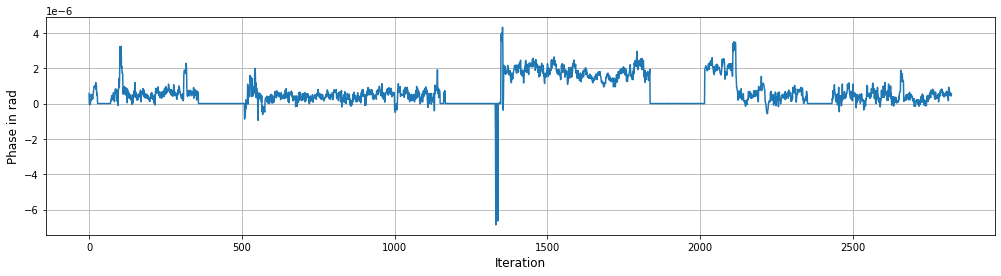

In [ ]:
figure = plt.figure()
figure.set_figwidth(17)
plt.plot(range(len(phi)), phi)
plt.grid(True)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Phase in rad", fontsize=12)
plt.show()

In [ ]:
with open("phases.csv", "w") as f:
  f.write("Phase in rad\n")
  for phase in phi:
    f.write(f"{phase}\n")